# Quake

By Cascade Tuholske, June 2020

Notebook finds zonal stats of populations for 2015 Nepal earthquakes by raster. <br><br>
**NOTE** CRS should be epsg:4326 for everything!

In [174]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
Patch = patches.Patch

In [2]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

In [3]:
def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

## Run on Shakemap Intensity Contours (MI) from USGS for Nepal 2015



#### All

In [4]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_NPL.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_NPL.tif']

In [5]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
nepal_polys_fn = DATA_PATH+'raw/USGS_Data/Nepal/shape/mi.shp'

col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)

In [6]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_all_NPL.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [7]:
# Save the poly sums
nepal_polys_sum.to_file(DATA_PATH+'/processed/nepal_quake_pop.shp')

#### Urban

In [ ]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*_urban_NPL.tif'))
rst_fns

In [ ]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
nepal_polys_fn = DATA_PATH+'raw/USGS_Data/Nepal/shape/mi.shp'

col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)


In [ ]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_urban_NPL.tif')


In [ ]:
#### Save the poly sums
nepal_polys_sum.to_file(DATA_PATH+'/processed/nepal_urban_quake_pop.shp')

nepal_polys_sum

#### Rural

In [ ]:
# Git tif files
rst_fns = glob('/Users/cascade/Github/PopGridCompare/data/interim/*_rural_NPL.tif')
rst_fns

In [ ]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
nepal_polys_fn = DATA_PATH+'raw/USGS_Data/Nepal/shape/mi.shp'

col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)


In [ ]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_rural_NPL.tif')


In [ ]:
#### Save the poly sums
nepal_polys_sum.to_file(DATA_PATH+'/processed/nepal_rural_quake_pop.shp')

# Plots

In [176]:
#### set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GPWv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

In [13]:
npl_all_fn = DATA_PATH+'processed/nepal_quake_pop.shp'
npl_all = gpd.read_file(npl_all_fn)

In [166]:
npl_rural_fn = DATA_PATH+'processed/nepal_rural_quake_pop.shp'
npl_rural = gpd.read_file(npl_rural_fn)

In [153]:
# Make data
def group(df):
    
    " Group and sum population by MI ranges, args is df quake pop"
    
    iv = df[(df['PARAMVALUE'] >= 4) & (df['PARAMVALUE'] < 5)].sum()[1:].reset_index()
    v = df[(df['PARAMVALUE'] >= 5) & (df['PARAMVALUE'] < 6)].sum()[1:]
    vi = df[(df['PARAMVALUE'] >= 6) & (df['PARAMVALUE'] < 7)].sum()[1:]
    vii = df[(df['PARAMVALUE'] >= 7)].sum()[1:]
    
    iv.rename(columns = {0: 'IV', 'index' : 'data'}, inplace = True)
    iv['V'] = v.values
    iv['VI'] = vi.values
    iv['VII'] = vii.values
    
    df_out = iv.transpose()
    df_out.drop('data', axis = 0, inplace = True)
    df_out.reset_index(inplace = True)
    df_out.columns = ['MI','ESRI16_sum','GHS15_sum','GPWv4_sum','LS15_sum','WP16_sum']
    
    return  df_out

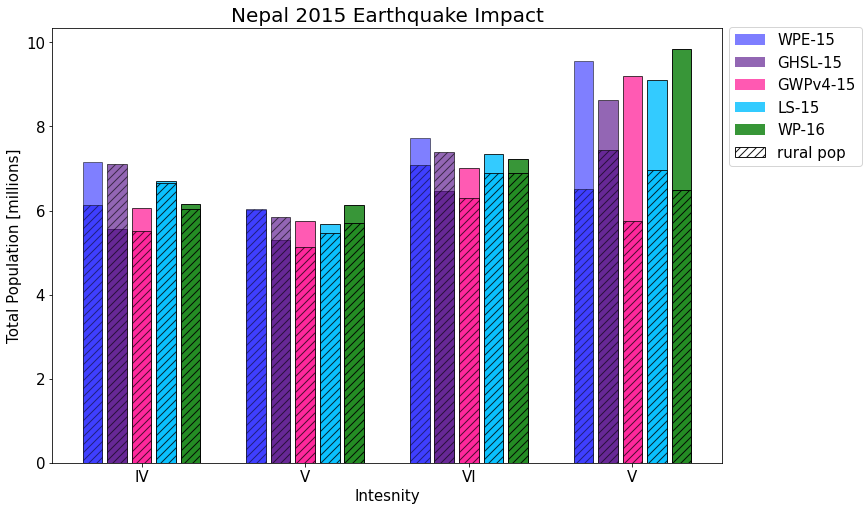

In [184]:
# Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (12, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**6

# All Quake
data = group(npl_all)

# Bar locations
a = [1-.3,2-.3,3-.3, 4-.3]
b = [1-.15,2-.15,3-.15,4-.15]
c = [1,2,3,4]
d = [1+.15,2+.15,3+.15,4+.15]
e = [1+.3,2+.3,3+.3,4+.3]

# plots
plt.bar(a, data.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black')
plt.bar(b, data.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black')
plt.bar(c, data.GPWv4_sum / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black')
plt.bar(d, data.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black')
plt.bar(e, data.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black')

# Fake plot for rural hatch legend 
plt.bar(e, data.WP16_sum / scale, width=0.12, align='center', alpha  = 0, color = 'white', ec = 'black',hatch = "///")

# rural floods
data = group(npl_rural)
plt.bar(a, data.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black', hatch = "///")
plt.bar(b, data.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black', hatch = "///")
plt.bar(c, data.GPWv4_sum / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black', hatch = "///")
plt.bar(d, data.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black', hatch = "///")
plt.bar(e, data.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black', hatch = "///")

# legend
legend_elements = [Patch(facecolor=ESRI16_c, alpha = 0.5, edgecolor=None, label='WPE-15'),
                  Patch(facecolor=GHS15_c, alpha = 0.6, edgecolor=None, label='GHSL-15'),
                  Patch(facecolor=GPWv4_c, alpha = 0.7, edgecolor=None, label='GWPv4-15'),
                  Patch(facecolor=LS15_c, alpha = 0.8, edgecolor=None, label='LS-15'),
                  Patch(facecolor= WP16_c, alpha = 0.9, edgecolor=None, label='WP-16'),
                  Patch(facecolor= 'white', alpha = 0.9,  hatch = '///', edgecolor='black', label='rural pop')]
plt.legend(handles = legend_elements, bbox_to_anchor=(1, 1.02), loc='upper left', ncol=1, fontsize = 15);

# Labels / Titles
axs.set_title('Nepal 2015 Earthquake Impact', size = 20)
axs.set_xlabel('Intesnity', fontsize = 15)
axs.set_ylabel('Total Population [millions]', fontsize = 15)

# Ticks
ticks_bar = ['IV', 'V', 'VI', 'V'];
plt.xticks([1,2,3,4], ticks_bar, fontsize = 15);
plt.yticks(fontsize = 15);

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Fig4.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

#### Old all

## Analysis

In [ ]:
# All
fn_in = DATA_PATH+'/processed/nepal_quake_pop.shp'
all_pop = gpd.read_file(fn_in)
df_all.head(1)

In [ ]:
all_pop [all_pop ['PARAMVALUE'] == 7.4].iloc[:,1:-1] / 10**6

In [ ]:
print('dif between max and min all nepal', 2.82526 - 2.33003)

In [ ]:
all_pop [all_pop ['PARAMVALUE'] > 6.8].iloc[:,1:-1]

In [ ]:
# All
all_pop = gpd.read_file(DATA_PATH+'/processed/nepal_quake_pop.shp')
all_pop['max'] = all_pop.iloc[:,1:5].values.max(1)
all_pop['min'] = all_pop.iloc[:,1:5].values.min(1)
all_pop['dif'] = all_pop['max'] - all_pop['min']

In [ ]:
# Urban 
urban_pop = gpd.read_file(DATA_PATH+'/processed/nepal_urban_quake_pop.shp')
urban_pop['max'] = urban_pop.iloc[:,1:5].values.max(1)
urban_pop['min'] = urban_pop.iloc[:,1:5].values.min(1)
urban_pop['dif'] = urban_pop['max'] - urban_pop['min']

In [ ]:
urban_pop[urban_pop['PARAMVALUE'] >= 7.2].iloc[:,:6] 

In [ ]:
# rural 
rural_pop = gpd.read_file(DATA_PATH+'/processed/nepal_rural_quake_pop.shp')
rural_pop['max'] = rural_pop.iloc[:,1:5].values.max(1)
rural_pop['min'] = rural_pop.iloc[:,1:5].values.min(1)
rural_pop['dif'] = rural_pop['max'] - rural_pop['min']

In [ ]:
rural_pop[rural_pop['PARAMVALUE'] == 7]

In [ ]:
#### plot it Nepal
data = nepal_polys_sum[nepal_polys_sum['PARAMVALUE'] > 6]
title = '2015 Nepal Earth Quake > 6 Intensity'
scale = 10**6

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

axs.scatter(data['PARAMVALUE'], data['ESRI16_sum'] / scale, color = ESRI16_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GHS15_sum'] / scale, color = GHS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GPWv4_sum'] / scale, color = GWPv4_c,  alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['LS15_sum'] / scale, color = LS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['WP16_sum'] / scale, color = WP16_c, alpha = 0.5, s = 70)

axs.set_title(title, size = 20 )
axs.set_xlabel('Quake Intensity', fontsize = 20)
axs.set_ylabel('Population [millions]', fontsize = 20)
#plt.ylim([100,10000000])

plt.yscale('linear')
axs.ticklabel_format(useOffset=False, style = 'plain')

labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16']
plt.legend(labels)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Nepal2015_all.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

#### Urban

In [ ]:
#### plot it Nepal
data = nepal_polys_sum[nepal_polys_sum['PARAMVALUE'] > 6]
title = 'Urban 2015 Nepal Earth Quake > 6 Intensity'
scale = 10**6

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

axs.scatter(data['PARAMVALUE'], data['ESRI16_sum'] / scale, color = ESRI16_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GHS15_sum'] / scale, color = GHS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GPWv4_sum'] / scale, color = GWPv4_c,  alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['LS15_sum'] / scale, color = LS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['WP16_sum'] / scale, color = WP16_c, alpha = 0.5, s = 70)

axs.set_title(title, size = 20 )
axs.set_xlabel('Quake Intensity', fontsize = 20)
axs.set_ylabel('Population [millions]', fontsize = 20)
#plt.ylim([100,10000000])

plt.yscale('linear')
axs.ticklabel_format(useOffset=False, style = 'plain')

labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16']
plt.legend(labels)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Nepal2015_urban.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

#### Rural

NameError: name 'ESRI16_c' is not defined

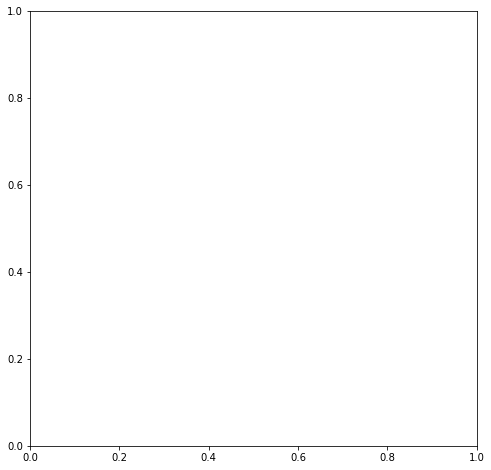

In [8]:
#### plot it Nepal
data = nepal_polys_sum[nepal_polys_sum['PARAMVALUE'] > 6]
title = 'Rural 2015 Nepal Earth Quake > 6 Intensity'
scale = 10**6

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

axs.scatter(data['PARAMVALUE'], data['ESRI16_sum'] / scale, color = ESRI16_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GHS15_sum'] / scale, color = GHS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GPWv4_sum'] / scale, color = GWPv4_c,  alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['LS15_sum'] / scale, color = LS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['WP16_sum'] / scale, color = WP16_c, alpha = 0.5, s = 70)

axs.set_title(title, size = 20 )
axs.set_xlabel('Quake Intensity', fontsize = 20)
axs.set_ylabel('Population [millions]', fontsize = 20)
#plt.ylim([100,10000000])

plt.yscale('linear')
axs.ticklabel_format(useOffset=False, style = 'plain')

labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16']
plt.legend(labels)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Nepal2015_rural.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')